# Example for training Spiking MLP on subset of NMNIST digits

## The problem:
Training digit classifier(0-9) on a subset(1000 training and 100 testing) of NMNIST digit spikes recorded using DVS camera. Just chagne the training list to for full NMNIST training.

## Load proper paths for SLAYER Pytorch source modules

In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../src")

## Load required modules

SLAYER modules are available as `snn`
* The `spike-layer` module will be available as `snn.layer`.
* The `yaml-parameter` module will be availabe as `snn.params`.
* The `spike-loss` module will be available as `snn.loss`.
* The `spike-classifier` module will be available as `snn.predict`.
* The `spike-IO` module will be available as `snn.io`.


In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
from learningStats import learningStats
from IPython.display import HTML
import zipfile

## Read SNN configuration from yaml file
See the file for all the configuration parameters. This configuration file will be used to describe the SNN. We will ignore the network configuration  describe in the yaml file here.

In [3]:
netParams = snn.params('network.yaml')

## Extract NMNISTsmall dataset
This is a subset of NMNIST dataset containing first 1000 training samples and first 100 testing samples. The original NMNSIT dataset consists of full MNIST samples converted into spikes using DVS sensor moved in three repeatable saccadic motion. For details and full dataset download links, refer to [https://www.garrickorchard.com/datasets/n-mnist](https://www.garrickorchard.com/datasets/n-mnist)

In [4]:
with zipfile.ZipFile('NMNISTsmall.zip') as zip_file:
    for member in zip_file.namelist():
        if not os.path.exists('./' + member):
            zip_file.extract(member, './')

## Defne the dataset class
The dataset definition follows standard PyTorch dataset definition.
Internally, it utilizes snn.io modules to read spikes and returns the spike in correct tensor format (CHWT).
* `datasetPath`: the path where the spike files are stored.
* `sampleFile`: the file that contains a list of sample indices and its corresponding clases.
* `samplingTime`: the sampling time (in ms) to bin the spikes.
* `sampleLength`: the length of the sample (in ms)

Note: This is a simple dataset class. A dataset that utilizes the folder hierarchy or xml list is easy to create.

In [5]:
# Dataset definition
class nmnistDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = datasetPath 
        self.samples = np.loadtxt(sampleFile).astype('int')
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]

        inputSpikes = snn.io.read2Dspikes(
                        self.path + str(inputIndex.item()) + '.bs2'
                        ).toSpikeTensor(torch.zeros((2,34,34,self.nTimeBins)),
                        samplingTime=self.samplingTime)
        desiredClass = torch.zeros((10, 1, 1, 1))
        desiredClass[classLabel,...] = 1
        # Input spikes are reshaped to ignore the spatial dimension and the neurons are placed in channel dimension.
        # The spatial dimension can be maintained and used as it is.
        # It requires different definition of the dense layer.
        return inputSpikes.reshape((-1, 1, 1, inputSpikes.shape[-1])), desiredClass, classLabel

    def __len__(self):
        return self.samples.shape[0]

## Define the network
The network definition follows similar style as standard PyTorch network definition, but it utilizes snn modules.

In [6]:
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # Initialize slayer
        slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # Define network functions
        # The commented line below should be used if the input spikes were not reshaped
        # self.fc1   = slayer.dense((34, 34, 2), 512)
        self.fc1   = slayer.dense((34*34*2), 512)
        self.fc2   = slayer.dense(512, 10)

    def forward(self, spikeInput):
        # Both set of definitions are equivalent. The uncommented version is much faster.

        # spikeLayer1 = self.slayer.spike(self.fc1(self.slayer.psp(spikeInput)))
        # spikeLayer2 = self.slayer.spike(self.fc2(self.slayer.psp(spikeLayer1)))

        spikeLayer1 = self.slayer.spike(self.slayer.psp(self.fc1(spikeInput)))
        spikeLayer2 = self.slayer.spike(self.slayer.psp(self.fc2(spikeLayer1)))		

        return spikeLayer2

## Initialize the network
* Define the device to run the code on.
* Create network instance.
* Create loss instance.
* Define optimizer module.
* Define training and testing dataloader.
* Cereate instance for learningStats.

In [7]:
# Define the cuda device to run the code on.
device = torch.device('cuda')

# Create network instance.
net = Network(netParams).to(device)

# Create snn loss instance.
error = snn.loss(netParams).to(device)

# Define optimizer module.
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)

# Dataset and dataLoader instances.
trainingSet = nmnistDataset(datasetPath =netParams['training']['path']['in'], 
                            sampleFile  =netParams['training']['path']['train'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])
trainLoader = DataLoader(dataset=trainingSet, batch_size=8, shuffle=False, num_workers=4)

testingSet = nmnistDataset(datasetPath  =netParams['training']['path']['in'], 
                            sampleFile  =netParams['training']['path']['test'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=8, shuffle=False, num_workers=4)

# Learning stats instance.
stats = learningStats()

## Visualize the spike data

In [8]:
input, target, label = trainingSet[0]
anim = snn.io.animTD(snn.io.spikeArrayToEvent(input.reshape((2, 34, 34, -1)).cpu().data.numpy()))
HTML(anim.to_jshtml())

In [9]:
# Delete the rogue temp-file
try:
    os.remove('None0000000.png')
except FileNotFoundError:
    pass

# Train the network
Train the network for 100 epochs.

In [10]:
for epoch in range(100):
    # Reset training stats.
    stats.training.reset()
    tSt = datetime.now()

    # Training loop.
    for i, (input, target, label) in enumerate(trainLoader, 0):
        # Move the input and target to correct GPU.
        input  = input.to(device)
        target = target.to(device) 

        # Forward pass of the network.
        output = net.forward(input)

        # Gather the training stats.
        stats.training.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.training.numSamples     += len(label)

        # Calculate loss.
        loss = error.numSpikes(output, target)

        # Reset gradients to zero.
        optimizer.zero_grad()

        # Backward pass of the network.
        loss.backward()

        # Update weights.
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Display training stats. (Suitable for normal python implementation)
        # if i%10 == 0:	stats.print(epoch, i, (datetime.now() - tSt).total_seconds())

    # Update training stats.
    stats.training.update()
    # Reset testing stats.
    stats.testing.reset()

    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, (input, target, label) in enumerate(testLoader, 0):
        input  = input.to(device)
        target = target.to(device) 

        output = net.forward(input)

        stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.testing.numSamples     += len(label)

        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
        # if i%10 == 0:	stats.print(epoch, i)

    # Update testing stats.
    stats.testing.update()
    if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())


Epoch :          0,    2608.1130 ms elapsed
loss = 3.0477       (min = 3.0477      )  	accuracy = 0.721      (max = 0.721     )
loss = 2.2334       (min = 2.2334      )  	accuracy = 0.83       (max = 0.83      )

Epoch :         10,    2740.5330 ms elapsed
loss = 0.26964      (min = 0.26964     )  	accuracy = 0.999      (max = 0.999     )
loss = 1.2294       (min = 1.1195      )  	accuracy = 0.93       (max = 0.94      )

Epoch :         20,    2762.3370 ms elapsed
loss = 0.12561      (min = 0.12561     )  	accuracy = 1          (max = 1         )
loss = 1.19         (min = 1.0549      )  	accuracy = 0.91       (max = 0.95      )

Epoch :         30,    2735.1320 ms elapsed
loss = 0.097307     (min = 0.097307    )  	accuracy = 1          (max = 1         )
loss = 1.1282       (min = 1.0349      )  	accuracy = 0.93       (max = 0.95      )

Epoch :         40,    2860.7610 ms elapsed
loss = 0.068855     (min = 0.068855    )  	accuracy = 1          (max = 1         )
loss = 1.1017      

## Plot the Results

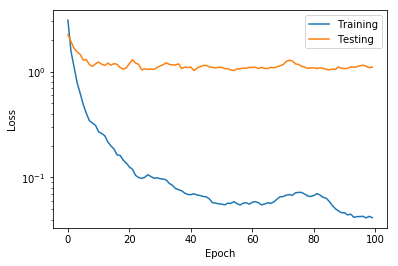

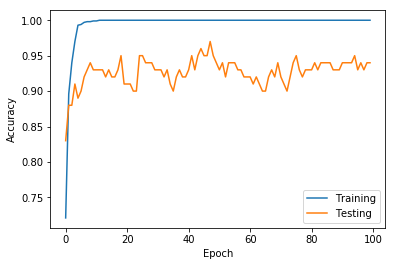

In [11]:
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing .lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing .accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()